In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

cuda


In [3]:
#generate data points
nx = 150
ny = 150
x = np.linspace(0,1,num=nx,endpoint=True)
y = np.linspace(0,1,num=ny,endpoint=True)
xx,yy = np.meshgrid(x,y)
X = np.concatenate((xx.reshape(-1,1),yy.reshape(-1,1)),axis=1)
xTensor = torch.tensor(xx.reshape(-1,1))
yTensor = torch.tensor(yy.reshape(-1,1))
XTensor = torch.tensor(X,dtype=torch.float32)
xGPU = xTensor.to(device)
yGPU = yTensor.to(device)
XGPU = XTensor.to(device)

In [4]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(2, 200)
        self.fc2 = nn.Linear(200, 900)
        self.fc3 = nn.Linear(900, 2)

        

        self.itstart = 1
        self.itend = 0

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = torch.sin(x)
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def loss_fn(self,predictions,targets):
        return torch.mean((predictions-targets)**2)
    
    def pdeLoss(self,X):
        xy = X.clone()
        xy.requires_grad=True
        TP = self.forward(xy)
        T = TP[:,0]
        P = TP[:,1]
        f_xy = torch.autograd.grad(TP,xy,torch.ones_like(xy).to(device),retain_graph=True,create_graph=True)[0]
        f_2xy = torch.autograd.grad(f_xy,xy,torch.ones_like(xy).to(device),retain_graph=True,create_graph=True)[0]
        print(f_xy)
        print(f_2xy)
        pde = f_2xy[:,0]**2+f_2xy[:,1]**2-X[:,0]**2+X[:,1]*torch.sin(X[:,1])
        return torch.mean(pde**2)
    
    def train(self,x,epochs,lr = 1e-5):
        self.optimizer = torch.optim.Adam(self.parameters(),lr=lr)
        # self.optimizer = torch.optim.LBFGS(self.parameters())
        self.itstart = self.itend+1
        self.itend += epochs+1
        for epoch in range(self.itstart,self.itend):
            loss = self.pdeLoss(x)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            if epoch % 500 == 0:
                print("Epoch:",epoch,"\t Loss:", loss.item())
        # self.optimizer.step(self.pdeLoss)

    def trainBFGS(self,x,iter):
        self.optimizer = torch.optim.LBFGS(self.parameters())
        def closure():
            loss = self.pdeLoss(x)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        for iteration in range(iter):
            self.optimizer.step(closure)



    
    def plot(self,x,target):
        y = self.forward(x)
        plt.figure()
        plt.plot(x.detach().cpu().numpy(),y.detach().cpu().numpy(),label = 'predicted')
        plt.plot(x.detach().cpu().numpy(),target,label='targets')
        plt.legend()
        plt.show()


net = Net()
net.to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=900, bias=True)
  (fc3): Linear(in_features=900, out_features=2, bias=True)
)


In [5]:
net.pdeLoss(XGPU)

tensor(0.1586, device='cuda:0', grad_fn=<MeanBackward0>)

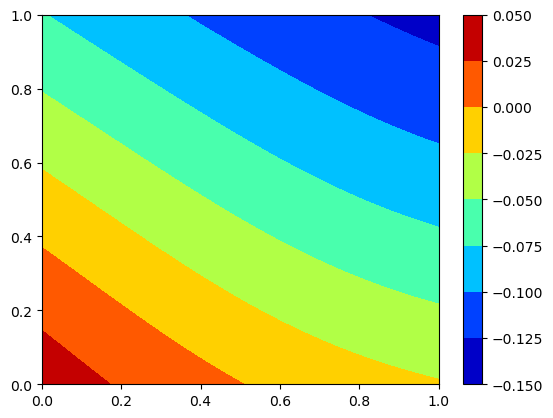

In [6]:
prediction = net(XGPU)
prediction = np.array(prediction.to('cpu').detach())
predT = prediction[:,0]
predPsi = prediction[:,1]
predT = predT.reshape(nx,ny)
predPsi = predPsi.reshape(nx,ny)
plt.figure()
plt.contourf(xx,yy,predT,cmap='jet')
plt.colorbar()
plt.show()

Epoch: 500 	 Loss: 0.06582198292016983
Epoch: 1000 	 Loss: 0.06558039039373398


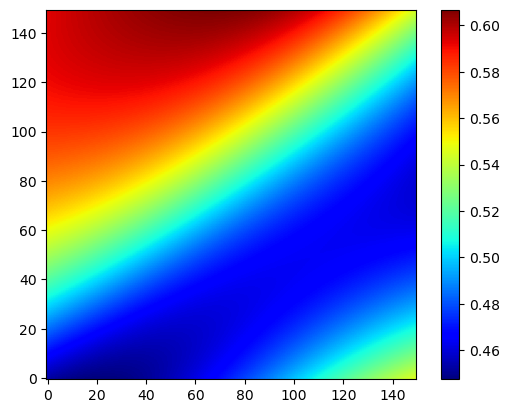

In [7]:
nepochs = 1000
lr = 1e-3

# net.trainBFGS(XGPU,nepochs)
net.train(XGPU,nepochs,lr)

prediction = net(XGPU)
prediction = np.array(prediction.to('cpu').detach())
predT = prediction[:,0]
predPsi = prediction[:,1]
predT = predT.reshape(nx,ny)
predPsi = predPsi.reshape(nx,ny)
plt.figure()
# plt.contourf(xx,yy,predT,cmap='jet')
plt.imshow(predT,cmap='jet',origin='lower')
plt.colorbar()
plt.show()